In [17]:
import itertools
from agent import Agent
from neo4j_controller import Neo4jController

In [3]:
agent = Agent(layout = "circular")
#expects neo4j database to be available at bolt://localhost:7687
neo4j_controller = Neo4jController(database = "ReasoningGraph") #works only if you have enterprise edition running of neo4j. Can be empty for default database instead.

In [22]:
agent.reset_graph()
# possible modelation of multiple choice question, where the answer candidates are weighted.
question = "What is 5 + 5?"
answer_candidates = ["10", "2 * 5", "ten", "30"]
ratings = [1.0, 0.5, 1.0, 0.01]
domain_node = agent.add_domain_node() # CommonSense node by default.
question_node = agent.check_node(question)
candidate_nodes = [agent.check_node(answer_candidate, previous = question_node) for answer_candidate in answer_candidates] #Results in nodes that are like "[Question][Answer1]"
candidate_node_ratings = {}
for candidate_node, rating in zip(candidate_nodes, ratings):
    candidate_node_ratings[candidate_node] = rating

# Testing Relation Between

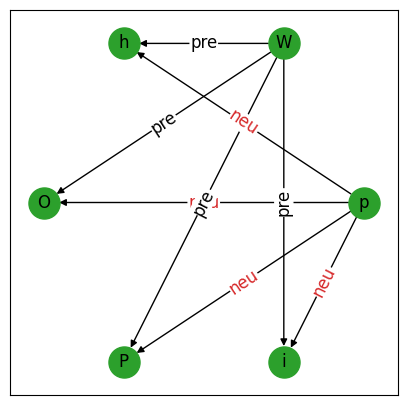

p: CommonSense
W: What is 5 + 5?
h: 10
O: 2 * 5
P: ten
i: 30



In [23]:
#first query label pairs for the relation between CommonSense node and all candidate nodes.
#Lets say the answers are possible but not strictly entailing.
queries = []
labels = []
for candidate_node in candidate_nodes:
    query, label = agent.relation_between(domain_node, candidate_node, label="neu") # Relation between CommonSense node and question-answer-node is neutral (possible)
    queries.append(query)
    labels.append(label)
agent.display_graph()

In [24]:
# Lets test the query, label pairs agains neo4j database.
query_after = agent.graph_to_cypher(operator="CREATE")
print(query_after)
neo4j_controller.reset_db()
neo4j_controller.excecute_query(query_after) #creates the full graph.
for query, label in zip(queries, labels):
    print(query)
    print(label)
    neo4j_controller.excecute_query_and_compare_with_label(query, label) #tests if the query passed to neo4j actually returns the expected value.

CREATE (p:Domain:CommonSense{text:'CommonSense'})-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(h:Statement{text:'10'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(O:Statement{text:'2 * 5'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(P:Statement{text:'ten'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(i:Statement{text:'30'}), (W:Statement{text:'What is 5 + 5?'})-[:Union {relation: 'pre', generated: '0'}]->(h), (W)-[:Union {relation: 'pre', generated: '0'}]->(O), (W)-[:Union {relation: 'pre', generated: '0'}]->(P), (W)-[:Union {relation: 'pre', generated: '0'}]->(i)
MATCH (W:Statement{text:'What is 5 + 5?'})-[:Union {relation: 'pre', generated: '0'}]->(h:Statement{text:'10'}), (p:Domain:CommonSense{text:'CommonSense'}),  (p)-[edge :Entailment]->(h) RETURN edge.relation AS relation
neu
MATCH (W:Statement{text:'What is 5 + 5?'})-[:Union {relation: 'pre', genera

# Testing Relation Weights

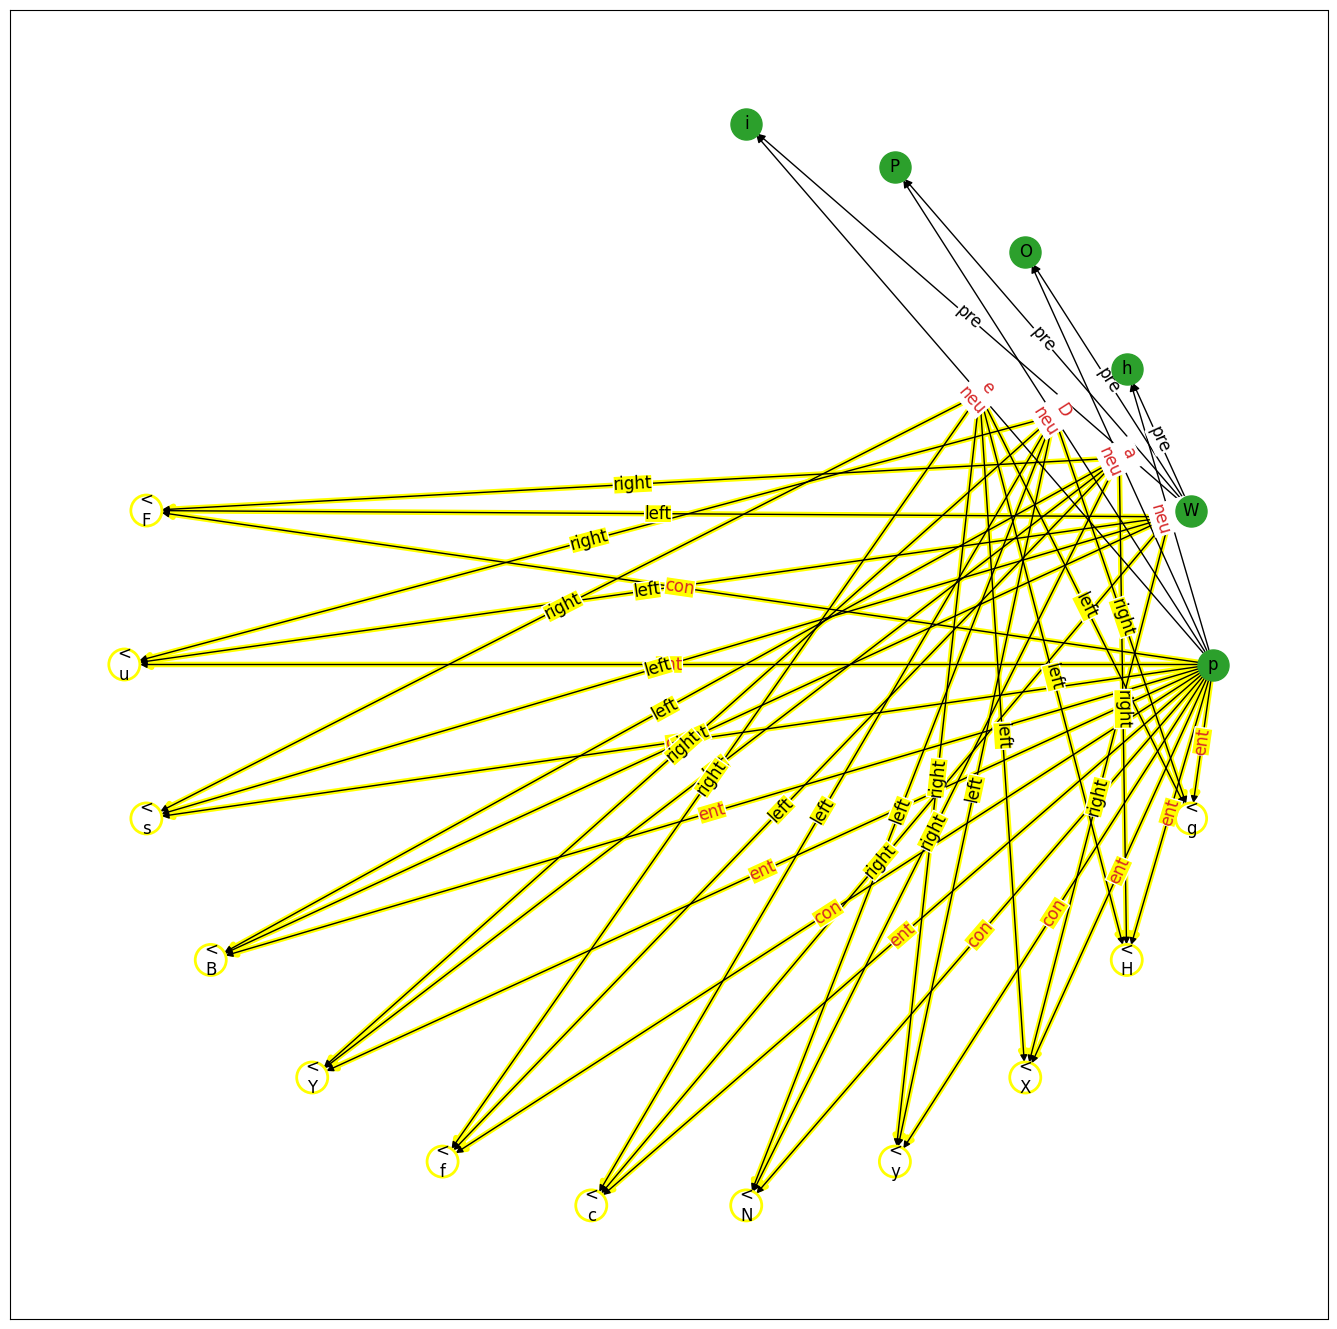

p: CommonSense
W: What is 5 + 5?
h: 10
O: 2 * 5
P: ten
i: 30
C: neu
a: neu
D: neu
e: neu
F: <
u: <
s: <
B: <
Y: <
f: <
c: <
N: <
y: <
X: <
H: <
g: <



In [25]:
# Next we test, if the model can learn to compare the neutral relations between each other.
compare_labels = {}
edges = []
for left_candidate, right_candidate in itertools.product(candidate_nodes, candidate_nodes):
    if left_candidate != right_candidate: # loop over crossproduct of candidate nodes (no self loops)
        left_rating = candidate_node_ratings[left_candidate]
        right_rating = candidate_node_ratings[right_candidate]
        compare_operator = "<" if left_rating != right_rating else "="
        compare_labels[((domain_node, left_candidate), (domain_node, right_candidate))] = "ent" if left_rating <= right_rating else "con"
        edges.append((domain_node, left_candidate))
compare_queries, relations = agent.compare_relations(edges, compare_context=domain_node, operator=compare_operator, labels = compare_labels)
agent.display_graph()


In [26]:
# Lets test the query, label pairs agains neo4j database.
query_after = agent.graph_to_cypher(operator="CREATE")
print(query_after)
neo4j_controller.reset_db()
neo4j_controller.excecute_query(query_after) #creates the full graph.
for query, label in zip(compare_queries, relations):
    print(query)
    print(label)
    neo4j_controller.excecute_query_and_compare_with_label(query, label) #tests if the query passed to neo4j actually returns the expected value.

CREATE (p:Domain:CommonSense{text:'CommonSense'})-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(h:Statement{text:'10'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(O:Statement{text:'2 * 5'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(P:Statement{text:'ten'}), (p)-[:Entailment {relation: 'neu', generated: '1', domain: 'CommonSense'}]->(i:Statement{text:'30'}), (p)-[:Edge {relation: 'source', generated: '0'}]->(C:EdgeNode{text:'neu'}), (p)-[:Edge {relation: 'source', generated: '0'}]->(a:EdgeNode{text:'neu'}), (p)-[:Edge {relation: 'source', generated: '0'}]->(D:EdgeNode{text:'neu'}), (p)-[:Edge {relation: 'source', generated: '0'}]->(e:EdgeNode{text:'neu'}), (p)-[:Entailment {relation: 'con', generated: '1', domain: 'CommonSense'}]->(F:CompareNode{text:'<'}), (p)-[:Entailment {relation: 'ent', generated: '1', domain: 'CommonSense'}]->(u:CompareNode{text:'<'}), (p)-[:Entailment {relation: 'con